
## Demonstrating Model Bias with a Simple Predictive Machine Learning Technique   

#### Abdulrahim Al Mulhim
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin





_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin



### Executive Summary




<div style="text-align: justify"> 
The main objective of the workflow was to demonstrate model bias with a simple predictive machine learning technique. The model bias was addressed using declustering and debiasing techniques. Afterward, simple predictive machine learning, linear regression, models were developed to demonstrate the impact of model bias on the model outcomes. The declustered model was generated after assigning weights to each sample while the debiased model was generated based on a derived data distribution. Both models illustrated that data bias impacts the linear regression outcomes. Therefore, it is crucial to take into account any model bias before applying any predictive machine learning model since biased data yield a biased model.</div>

### Import Packages

The first step is to import the required packages to run the workflow. 

In [1]:
import geostatspy.GSLIB as GSLIB                         # GSLIB utilities that is used for visualization
import geostatspy.geostats as geostats                   # GSLIB methods convert to Python        
import numpy as np                                       # ndarrys for gridded data
import pandas as pd                                      # DataFrames for tabular data
import pandas.plotting as pd_plot                        # used in plotting
import matplotlib.pyplot as plt                          # used in plotting
from statsmodels.stats.weightstats import DescrStatsW    # used to find data statistics
from statistics import covariance                        # used to find the covariance 

### Load Data




The following workflow applies to a bias synthetic dataset data that was generated using a modified workflow that was developed by Professor Michael Pyrcz (@GeostatsGuy). The modification was to add production data. The workflow can be found [HERE](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/make_nonlinear_MV_spatial_data_v7.ipynb).    

The main features in the workflow are:

* **Porosity (Por)**: The void space in the rock in percentage
* **Permeability (Perm)**: The ability of a fluid to flow through a porous media in milliDarcy
* **Acoustic Impedance (AI)**:  Product of sonic velocity and rock density in units of $\frac{kg}{m^2s}x10^3$
* **Production (Prod)**: Expected production from a well in MCFPD



In [2]:
df = pd.read_csv('spatial_nonlinear_MV_facies.csv') # importing the data
df.head(n=5)                                        # show the first 5 data point

,Unnamed: 0,X,Y,Por,Perm,AI,Facies,Prod
0,349,400,249,16.554245,851.200000,4526.505800,1,3000.285270
1,687,580,799,19.213731,673.532665,3768.074955,1,3958.465114
2,136,750,649,14.721938,1061.551680,4073.413110,1,3487.714621
3,22,750,709,19.569837,494.463106,4113.103072,1,4870.392125
4,194,475,275,17.608297,602.222770,4116.294391,1,3750.841187


### Basic Data Checking and Visualization



<div style="text-align: justify"> The above data table shows the sample number, X and Y coordinates in meters, porosity, permeability, acoustic impedance, facies, and production. The next step is to get an overview and general understanding of the data. First, we calculate the summary statistics for the data.


In [3]:
df=df.iloc[:,1:]           # dropping the first column (sample number) 
df.describe().transpose()  # Shows the transposed summary statistics

,count,mean,std,min,25%,50%,75%,max
X,345.0,487.666667,286.682846,0.000000,260.000000,470.000000,725.000000,990.000000
Y,345.0,532.002899,287.235343,9.000000,275.000000,539.000000,775.000000,999.000000
Por,345.0,14.164695,6.352879,0.000000,11.257624,15.429456,18.808342,28.470384
Perm,345.0,619.223694,361.833361,3.674186,307.751022,602.222770,944.872450,1414.297680
AI,345.0,4292.908682,397.205886,3614.824143,3996.213957,4224.848623,4526.505800,5718.065178
Facies,345.0,0.831884,0.374512,0.000000,1.000000,1.000000,1.000000,1.000000
Prod,345.0,3000.898030,1127.637196,0.000000,2374.619649,3261.336075,3809.791128,4928.198730



Now, we plot the data to understand how the samples are distributed across the area of interest.

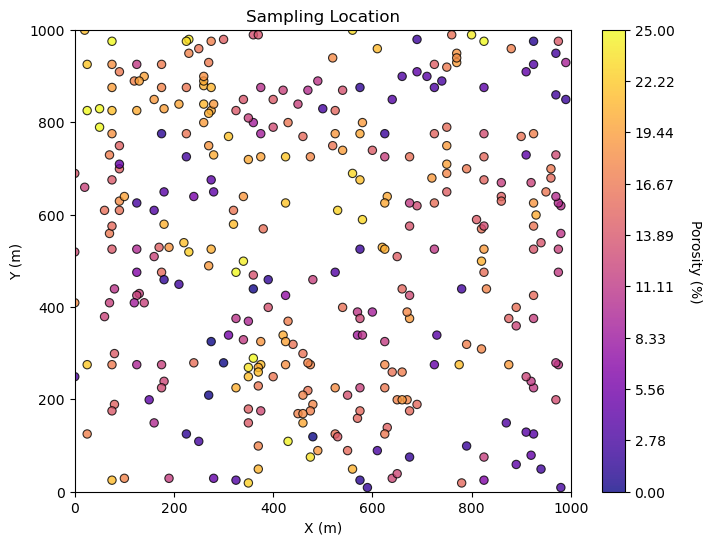

In [4]:
#Visulaize the data locations
GSLIB.locmap(df,'X','Y','Por',0,1000,0,1000,0,25,'Sampling Location','X (m)','Y (m)','Porosity (%)',plt.cm.plasma,'locmap_Porosity')
plt.show()

The above plot shows high local sampling density in some areas resulting in model bias in terms of data sampling.

### Model Bias Demonstration and Assessment

Here is a short summary of the workflow: 

1. Utilize feature engineering, if needed, to improve the performance of predictive machine learning

2. Perform data declustering

3. Generate debiased data distribution

4. Develop simple predictive machine learning models with the original, declustered, debiased data

5. Analyze data bias impact by comparing the original model with the declustered and debiased models


### 1. Feature Engineering




<div style="text-align: justify"> 
Feature engineering is using domain expertise to extract features from raw data. For the data used in the workflow, there are two rock facies: sandstone (1) and shale (0). Hence, only one rock facies should be used in a predictive machine model.  
</div>

The workflow will be focusing on the sandstone data only. So, we will drop the shale data.

In [5]:
df_sand = df.drop(df[df['Facies']==0].index)                #filtered sandstone data only
df_shale = df.drop(df[df['Facies']==1].index)               #filtered shlae data only

#Show details about the number of samples 
print('The number of total collected samples is  '+str(len(df))+ '  Sample     ')
print('Number of Sandstone Samples is  '+str(len(df_sand))+ '  Sample     ')
print('Number of Shale samples is  '+ str(len(df_shale))+ '  Sample'  )   

The number of total collected samples is  345  Sample     
Number of Sandstone Samples is  287  Sample     
Number of Shale samples is  58  Sample




Now, we can see the porosity, permeability, and acoustic impedance sandstone data distribution. 


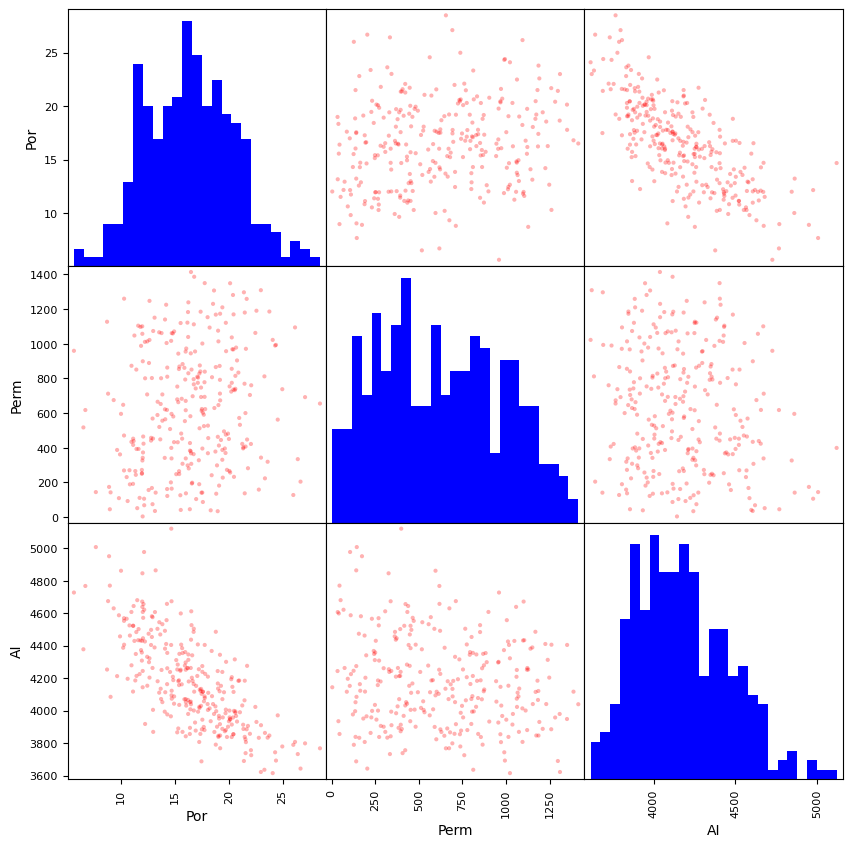

In [6]:
# visulaize the sandstone data in a matrix scatter plot
pd_plot.scatter_matrix(df_sand.iloc[:,2:5], alpha = 0.3,figsize=(10, 10),color = 'red',
                       hist_kwds={'bins':25,'color':['blue']}) 
plt.show()



### 2. Data Declustering 




<div style="text-align: justify"> 
After having the data ready, the data can be declustered. The data declustering process can be completed by assigning each datum a weight based on its closeness to the surrounding data. In the workflow, the weights are assigned based on the cell size and the declustered mean for the cell. 

    

The first step in declustering is to assign weights to the data. 


In [7]:
w, cell_sizes, dm = geostats.declus(df_sand,'X','Y','Por',iminmax = 1,
                                    noff= 10, ncell=100,cmin=10,cmax=500) #declustering over 100 cell size
df_sand['weight'] = w                            # add weights to the sample data DataFrame


There are 287 data with:
   mean of      16.45544493352764 
   min and max  5.647524073194251 and 28.470384473858324
   standard dev 4.0984663683333205 



After having the weight assignments, we visualize the data.


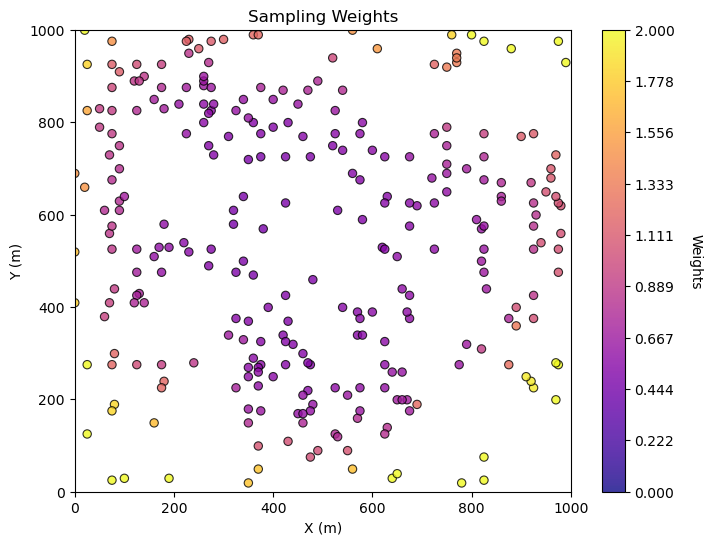

In [8]:
#visulaize the data locations after assigning the weights
GSLIB.locmap(df_sand,'X','Y','weight',0,1000,0,1000,0,2,'Sampling Weights','X (m)','Y (m)',
             'Weights',plt.cm.plasma,'locmap_Weights')
plt.show()

<div style="text-align: justify"> 
Now, we can see each data weight and how it varies with local sampling density over the area of interest. Furthermore, we can generate the porosity declustered distribution and compare it with naïve data. 

The Naïve porosity mean is        16.46
The declustered porosity mean is  16.08


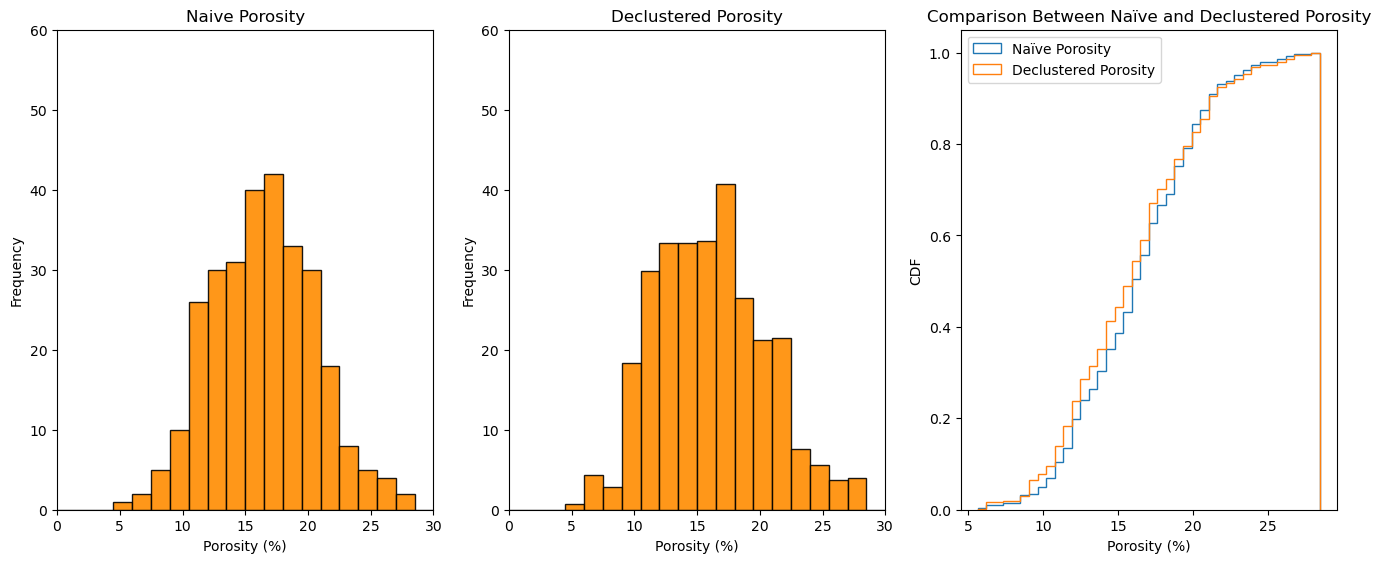

In [9]:
plt.subplot(131)        #plotting the naïve porosity
GSLIB.hist_st(df_sand['Por'],0,30,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Naive Porosity")
plt.ylim(0,60)

plt.subplot(132)        #plotting the declustered porosity
GSLIB.hist_st(df_sand['Por'],0,30,log=False,cumul=False,bins=20,weights=df_sand['weight'],xlabel="Porosity (%)",title="Declustered Porosity")
plt.ylim(0,60)

plt.subplot(133)        #plotting the CDF porosity
plt.hist(df_sand['Por'], bins=40, density=True, cumulative=True, histtype='step', weights=None,label='Naïve Porosity')
plt.hist(df_sand['Por'], bins=40, density=True, cumulative=True, histtype='step', weights=df_sand['weight'], label='Declustered Porosity')
plt.legend(),plt.title('Comparison Between Naïve and Declustered Porosity'),plt.xlabel('Porosity (%)'),plt.ylabel('CDF')

#calculating and showing the naïve and declustered porosity means
avg_por=np.average(df_sand['Por'].values,weights=None)
avg_cpor=np.average(df_sand['Por'].values,weights=df_sand['weight'].values)
print('The Naïve porosity mean is        ' + str(round(avg_por,2))), print('The declustered porosity mean is  ' + str(round(avg_cpor,2)))


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()


 
The utilized declustering technique above is from the [GeostatsPy_declustering](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_declustering.ipynb) workflow developed by Professor Michael Pyrcz  (@GeostatsGuy).

### 3. Data Debiasing 

<div style="text-align: justify"> 
In addition to data declustering, clustered data can be addressed by performing debiasing. In data debiasing, an entire new distribution is derived based on a secondary data source. In this workflow, the acoustic impedance is used as the secondary data source to derive the porosity data (Krygowski 2004*). The porosity can be derived using the following:

    
    


$$\Delta t = \frac{1}{\rho x AI}$$

$$\phi = \frac{\Delta t - \Delta t_{matrix}}{\Delta t_{fluid} - \Delta t_{matrix} }x \frac{1}{C_p} $$

$$ C_p = \frac{\Delta t_{shale} x C}{100} $$

Where 

$$ \rho_{sandstone} = 2650 \frac{kg}{m^3}$$

$$ \rho_{shale} = 2300 \frac{kg}{m^3}$$

$$\Delta t_{sandstone} = 55 \frac{\mu sec}{ft}$$

$$\Delta t_{fluid} = 626 \frac{\mu sec}{ft}$$

$$ C = 1 $$

Then, the porosity derivation from acoustic impedance will be computed.

<div style="text-align: justify">   
    

*Krygowski, D. 2004. Basic Well Log Analysis, 2nd Edition. The American Association of Petroleum Geologists.
    

In [10]:

df_sand['dt']=(1)/((df_sand['AI']/2650)*1000)*(10**6)/3.28     # estimating the sandstone transit time 
df_shale['dt']=(1)/((df_shale['AI']/2300)*1000)*(10**6)/3.28   # estimating the shale transit time 
cp=np.average(df_shale['dt'].values)/100                       # estimating the compaction factor
df_sand['Por_est']=(df_sand['dt']-55)/(626-55)*1/(cp/100)      # derive the porosity distribution from AI 



<div style="text-align: justify"> 
After deriving the new distribution, let’s compare the original and debiased distributions 

The Naïve porosity  mean is   16.46
The Debiased porosity  mean is  16.86


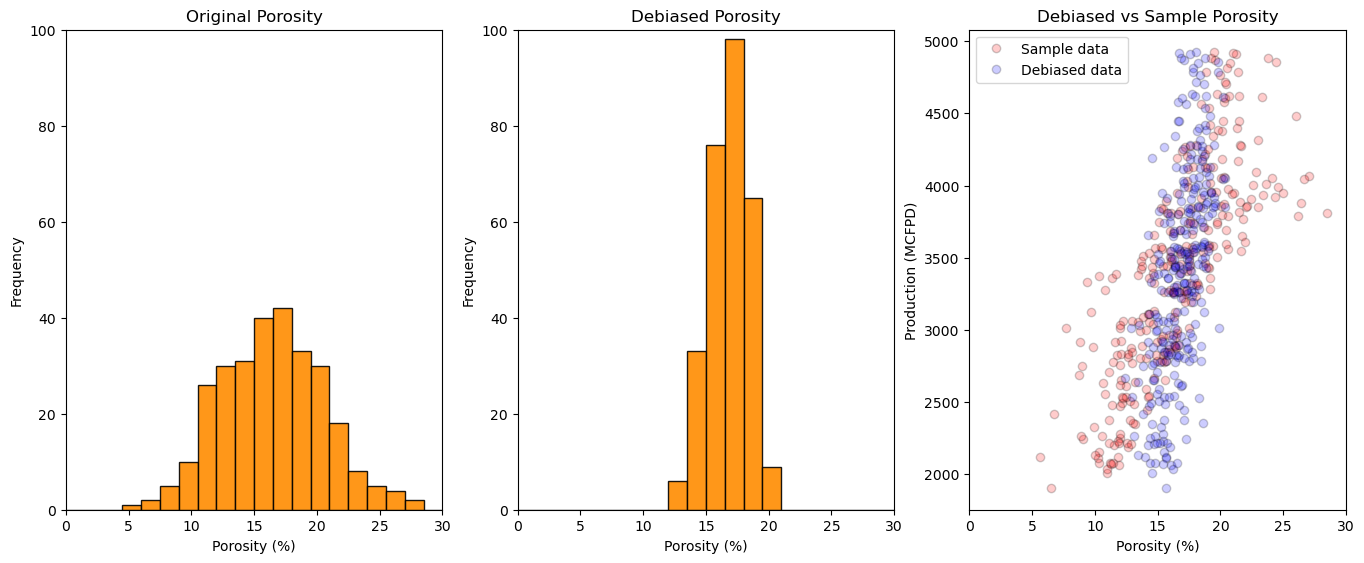

In [11]:

plt.subplot(131)   # plotting the original porosity distribution
GSLIB.hist_st(df_sand['Por'],0,30,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Original Porosity")
plt.ylim(0,100)

plt.subplot(132)   # plotting the debiased porosity distribution
GSLIB.hist_st(df_sand['Por_est'],0,30,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Debiased Porosity")
plt.ylim(0,100)

plt.subplot(133)   # comparing the original and debiased porosity samples
plt.plot(df_sand['Por'], df_sand['Prod'], 'o', label='Sample data', color = 'red', alpha = 0.2, markeredgecolor = 'black')
plt.plot(df_sand['Por_est'], df_sand['Prod'], 'o', label='Debiased data', color = 'blue', alpha = 0.2, markeredgecolor = 'black')
plt.title('Debiased vs Sample Porosity'),plt.xlabel('Porosity (%)'),plt.ylabel('Production (MCFPD)'),plt.legend(),plt.xlim(0,30)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.2)

#calculating and showing the naïve and declustered porosity means
avg_debpor=np.average(df_sand['Por_est'].values)
print('The Naïve porosity  mean is   ' + str(round(avg_por,2))), print('The Debiased porosity  mean is  ' + str(round(avg_debpor,2)))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()


### 4.  Linear Regression

<div style="text-align: justify"> 
Now, simple predictive machine learning models will be generated using linear regression to estimate the production from porosity. There are three data distributions to be compared using linear regression: original, declustered, and debiased data distributions. The linear regression will be performed as following: 

    
    


$$ y =b_0 + b_1 x$$

Where 

$$ b_0 = \bar{y}-b_1\bar{x} $$

$$ b_1 = \frac{\sigma_{XY}}{\sigma^2_{X}} $$


<div style="text-align: justify"> 
Let’s calculate the linear regression for each data distribution

    
    


In [12]:
#original data linear regression model
covo=np.cov(df_sand['Por'],df_sand['Prod'])[0][1]   #covariance calculation 
weighted_stats_poro=DescrStatsW(df_sand['Por'])     #porosity statistics  
weighted_stats_prodo=DescrStatsW(df_sand['Prod'])   #production statistics
varo=weighted_stats_poro.var                        #variance calculation
avgporo=weighted_stats_poro.mean                    #porosity mean
avgprodo=weighted_stats_prodo.mean                  #production mean
b1o=covo/varo                                       #slope
b0o=avgprodo-b1o*avgporo                            #intercept

#declustered data linear regression model
cov_dec=np.cov(df_sand['Por'],df_sand['Prod'],aweights=df_sand['weight'])[0][1]        #weighted covariance calculation 
weighted_stats_por_dec=DescrStatsW(df_sand['Por'],weights=df_sand['weight'])           #porosity weighted statistics 
weighted_stats_prod_dec=DescrStatsW(df_sand['Prod'],weights=df_sand['weight'])         #production weighted statistics
var_dec=weighted_stats_por_dec.var                                                     #weighted variance calculation
avgpor_dec=weighted_stats_por_dec.mean                                                 #weighted porosity mean
avgprod_dec=weighted_stats_prod_dec.mean                                               #weighted production mean
b1_dec=cov_dec/var_dec                                                                 #weighted slope
b0_dec=avgprod_dec-b1_dec*avgpor_dec                                                   #weighted intercept
 
#debiased data linear regression model
cov_deb=np.cov(df_sand['Por_est'],df_sand['Prod'])[0][1]        #covariance calculation 
weighted_stats_por_deb=DescrStatsW(df_sand['Por_est'])          #porosity statistics
weighted_stats_prod_deb=DescrStatsW(df_sand['Prod'])            #production statistics
var_deb=weighted_stats_por_deb.var                              #debiased variance calculation
avgpor_deb=weighted_stats_por_deb.mean                          #debiased porosity mean
avgprod_deb=weighted_stats_prod_deb.mean                        #debiased production mean
b1_deb=cov_deb/var_deb                                          #debiased slope
b0_deb=avgprod_deb-b1_deb*avgpor_deb                            #debiased intercept

#show the intercept and slope for each model
print('Original slope (b1):   ' + str(round(b1o,2))),print('Original Inetercept (b0):  ' + str(round(b0o,2)))
print('Declustered slope (b1):   ' + str(round(b1_dec,2))),print('Declustered Inetercept (b0):  ' + str(round(b0_dec,2)))
print('Debiased Slope (b1):   ' + str(round(b1_deb,2))),print('Debiased Inetercept (b0):  ' + str(round(b0_deb,2)))



Original slope (b1):   138.98
Original Inetercept (b0):  1113.89
Declustered slope (b1):   128.28
Declustered Inetercept (b0):  1299.82
Debiased Slope (b1):   276.32
Debiased Inetercept (b0):  -1258.1


(None, None)

<div style="text-align: justify"> 
    
Now we can plot the generated linear regression model for the original data, declustered, and debiased data.
    


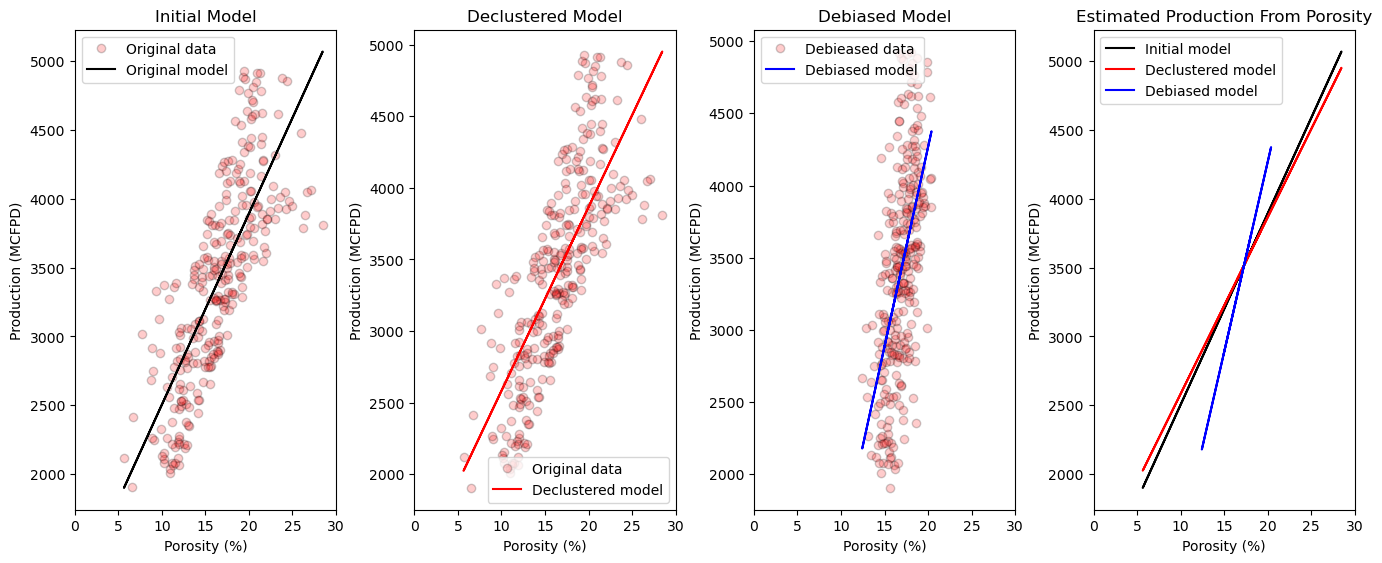

In [13]:
#plot original distribution linear regression model
plt.subplot(141)
plt.plot(df_sand['Por'], df_sand['Prod'], 'o', label='Original data', color = 'red', alpha = 0.2, markeredgecolor = 'black')
plt.plot(df_sand['Por'], b0o + b1o*df_sand['Por'], label='Original model', color = 'black')
plt.title('Initial Model'),plt.xlabel('Porosity (%)'),plt.ylabel('Production (MCFPD)'),plt.legend(),plt.xlim(0,30)

#plot declustered distribution linear regression model
plt.subplot(142)
plt.plot(df_sand['Por'], df_sand['Prod'], 'o', label='Original data', color = 'red', alpha = 0.2, markeredgecolor = 'black')
plt.plot(df_sand['Por'], b0_dec + b1_dec*df_sand['Por'], label='Declustered model', color = 'red')
plt.title('Declustered Model'),plt.xlabel('Porosity (%)'),plt.ylabel('Production (MCFPD)'),plt.legend(),plt.xlim(0,30)

#plot debiased distribution linear regression model
plt.subplot(143)
plt.plot(df_sand['Por_est'], df_sand['Prod'], 'o', label='Debieased data', color = 'red', alpha = 0.2, markeredgecolor = 'black')
plt.plot(df_sand['Por_est'], b0_deb + b1_deb*df_sand['Por_est'], label='Debiased model', color = 'blue')
plt.title('Debiased Model'),plt.xlabel('Porosity (%)'),plt.ylabel('Production (MCFPD)'),plt.legend(),plt.xlim(0,30)


#comparing the linear regression models
plt.subplot(144)
plt.plot(df_sand['Por'], b0o + b1o*df_sand['Por'], label='Initial model', color = 'black')
plt.plot(df_sand['Por'], b0_dec + b1_dec*df_sand['Por'], label='Declustered model', color = 'red')
plt.plot(df_sand['Por_est'], b0_deb + b1_deb*df_sand['Por_est'], label='Debiased model', color = 'blue')
plt.title('Estimated Production From Porosity'),plt.xlabel('Porosity (%)'),plt.ylabel('Production (MCFPD)'),plt.legend(),plt.xlim(0,30)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.2)
plt.show()




<div style="text-align: justify"> 
    
The impact of the model bias can be shown on the linear regression models.



### Results


<div style="text-align: justify"> 
The original dataset was converted to declustered and debiased dataset. Both datasets were generated to address and demonstrate model bias. The declustering was performed by assigning data weight to the data while the debiasing was completed by deriving a new distribution from the acoustic impedance. Linear regression was utilized to illustrate how the model bias impacts the production prediction from porosity for all data sets. The declustered model showed that there was a shift in the prediction from the original model due to the data bias. Similarly, the debiased model output was addressing the data bias. However, it is crucial to keep in mind that the new distribution is based on secondary data. Hence, the quality of the new distribution depends on the data quality of the secondary data. Furthermore, the developed models demonstrate that biased data yields biased model. All in all, model bias should be taken into account when utilizing any predictive machine learning technique. 

### About Me


<div style="text-align: justify"> 
I am currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin interested in reservoir management and carbon storage and utilization. I hope this workflow was helpful.





*Abdulrahim Al Mulhim*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
